In [260]:
from os import listdir
from collections import defaultdict
from math import comb, ceil

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker
import seaborn as sns
import numpy as np

import pandas as pd

sns.set()
sns.set_palette("bright")
sns.set_style("whitegrid")

matplotlib.rcParams['font.serif'] = "cmb10"
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True

In [17]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return f"<p>{fontname}: <span style='font-family:{fontname}; font-size:24px;'>{fontname}</p>"

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist])) if "cm" in font])

HTML("<dif style='column-count:2;'>{}</div>".format(code))

In [5]:
import shutil
import matplotlib

shutil.rmtree(matplotlib.get_cachedir())

# RUN DATA

## AMD:

Model name:          AMD EPYC 7452 32-Core Processor

Kernel: 4.18.0-372.9.1.el8.x86_64

## Intel:

Model name:          Intel(R) Xeon(R) CPU E7-8890 v4 @ 2.20GHz

Kernel: 4.18.0-348.2.1.el8_5.x86_64

In [261]:
m = ""
di = f"../res/{m}"
checksums = {}
for fn in listdir(di):
    if "txt" not in fn:
        continue
    acc = 0
    ran = 0
    sel = 0
    with open(di + fn) as inf:
        for l in inf:
            if "access checksum" in l:
                acc = int(l.split()[-1])
            elif "rank checksum" in l:
                ran = int(l.split()[-1])
            elif "select checksum" in l:
                sel = int(l.split()[-1])
    ds = fn.split('_')[-1]
    if ds not in checksums:
        checksums[ds] = [(fn, acc, ran, sel)]
    else:
        checksums[ds].append((fn, acc, ran, sel))
print(m, ":")
for ds, tups in checksums.items():
    print("======", ds, "=======")
    acc = defaultdict(int)
    ran = defaultdict(int)
    sel = defaultdict(int)
    for t in tups:
        acc[t[1]] += 1
        ran[t[2]] += 1
        if "HYB" not in t[0]:
            sel[t[3]] += 1
    acc_c = sorted(acc.items(), key=lambda x: -x[1])[0][0]
    ran_c = sorted(ran.items(), key=lambda x: -x[1])[0][0]
    sel_c = sorted(sel.items(), key=lambda x: -x[1])[0][0]
    print(acc_c, ran_c, sel_c)
    for t in tups:
        if t[1] != acc_c:
            print(t)
            continue
        if t[2] != ran_c:
            print(t)
            continue
        if "HYB" not in t[0] and t[3] != sel_c:
            print(t)

 :
====== RND-6.bin.txt =======
156214 671869365506950 42983283277999139
('HYBRRR_256_32_RND-6.bin.txt', 156658, 671869360597849, 671869360597849)
====== RND-8.bin.txt =======
39660 168040053646786 42963243217847091
('HYBRRR_256_32_RND-8.bin.txt', 39768, 168040053630138, 168040053630138)
====== RND-9.bin.txt =======
18619 83969158889084 42929940817611284
('HYBRRR_256_32_RND-9.bin.txt', 18619, 83969158888727, 83969158888727)
====== RND-7.bin.txt =======
76282 335902931212255 42940378589030903
('HYBRRR_256_32_RND-7.bin.txt', 76632, 335902930762431, 335902930762431)
====== rnd-50.16MB.txt =======
0 0 0
====== bv-dump.bin.txt =======
2503280 10455494743730396 40748480512100248
('H0R_64_32_NOOPT_bv-dump.bin.txt', 0, 0, 0)
('SDSL_24_32_NOOPT_bv-dump.bin.txt', 0, 0, 0)
('H0I_64_32_NOOPT_bv-dump.bin.txt', 0, 0, 0)
('SDSL_31_32_NOOPT_bv-dump.bin.txt', 0, 0, 0)
('SDSL_63_32_NOOPT_bv-dump.bin.txt', 0, 0, 0)
('SDSL_15_32_NOOPT_bv-dump.bin.txt', 0, 0, 0)
('HYBRRR_256_32_bv-dump.bin.txt', 2491100, 1

In [267]:
stuff = []
machine = ""
di = f"../res/{machine}"
for fn in listdir(di):
    if "txt" not in fn or "NOOPT" in fn or "SDSL_15_32" in fn or "rnd-50.16MB" in fn:
        continue
    d = {}
    with open(di + fn) as inf:
        for l in inf:
            if "access time" in l:
                d["access"] = float(l.split()[-1])
            elif "plain size" in l:
                d["elems"] = float(l.split()[-1])
            elif "rank time" in l:
                d["rank"] = float(l.split()[-1])
            elif "select time" in l and "HYB" not in fn:
                d["select"] = float(l.split()[-1])
            elif "rrr size" in l:
                d["total_bytes"] = float(l.split()[-1])
            elif "C array" in l:
                d["C bytes"] = float(l.split()[-1])
            elif "F array" in l:
                d["F bytes"] = float(l.split()[-1])
            elif "partial sums" in l:
                d["overhead bytes"] = float(l.split()[-1])
            elif "lookup bytes" in l:
                d["lookup bytes"] = float(l.split()[-1])
            elif "construct time" in l:
                d["build time"] = int(l.split()[-1]) / 1000
    fn_arr = fn.split('_')
    d["data_set"] = fn_arr[-1]
    d["block_size"] = int(fn_arr[1])
    d["CR"] = (d["total_bytes"] + (d["lookup bytes"] if "lookup bytes" in d else 0)) / d["elems"]
    if "SDSL" in fn_arr[0]:
        d["type"] = fn_arr[0]
    else:
        d["type"] = fn_arr[0] + fn_arr[1]
    if "GAP" in fn or "LOO" in fn:
        d["gap_size"] = fn_arr[3]
    d["machine"] = machine if machine else "laptop"
    stuff.append(d)

df = pd.DataFrame.from_dict(stuff)
for di in stuff:
    if di["data_set"] == "bv-dump.bin.txt" and di["type"] == "SDSL":
        print(di)

{'elems': 1032709032.0, 'build time': 45.249, 'total_bytes': 831012587.0, 'C bytes': 36306193.0, 'F bytes': 786512240.0, 'overhead bytes': 8194146.0, 'lookup bytes': 2130498.0, 'access': 1112.18, 'rank': 1108.74, 'select': 2676.83, 'data_set': 'bv-dump.bin.txt', 'block_size': 256, 'CR': 0.8067549127429342, 'type': 'SDSL', 'machine': 'laptop'}
{'elems': 1032709032.0, 'build time': 24.874, 'total_bytes': 924871499.0, 'C bytes': 166565985.0, 'F bytes': 690638032.0, 'overhead bytes': 67667474.0, 'lookup bytes': 34896.0, 'access': 312.463, 'rank': 325.647, 'select': 1080.24, 'data_set': 'bv-dump.bin.txt', 'block_size': 31, 'CR': 0.8956117999750388, 'type': 'SDSL', 'machine': 'laptop'}
{'elems': 1032709032.0, 'build time': 26.207, 'total_bytes': 973203299.0, 'C bytes': 215147729.0, 'F bytes': 670651752.0, 'overhead bytes': 87403810.0, 'lookup bytes': 34882.0, 'access': 284.384, 'rank': 303.512, 'select': 1083.35, 'data_set': 'bv-dump.bin.txt', 'block_size': 24, 'CR': 0.9424127714998042, 'typ

In [207]:
testset = "laptop"

In [208]:
files = [
    'WT-WEB-1GB.txt', 
    'WT-DNA-1GB.txt', 
    'bv-dump.bin.txt', 
    'RND-1.bin.txt',
    'RND-5.bin.txt',
    'RND-10.bin.txt',
]#, 'rnd-50.16MB.txt']

In [135]:
bv_stats = dict()
for fn in files:
    actual_fn = fn[:-4]
    print(actual_fn)
    bv_stats[fn] = !../utils/bv_stat ../../h0_data/{actual_fn}

WT-WEB-1GB
WT-DNA-1GB
bv-dump.bin
RND-1.bin
RND-5.bin
RND-10.bin


In [209]:
stat_table = """\\hline
{Dataset} & {$n$} & {$H_0$}  & {mean $H_0$ entropy} & {Fraction of uniform} \\\\
 & & & {of 64-bit blocks} & {64-bit blocks} \\\\
\\hline
"""
for k, v in bv_stats.items():
    things = dict()
    for l in v:
        if "loaded with" in l:
            things["n"] = l.split()[-2]
        if l.startswith("H0 entropy"):
            things["H0"] = l.split()[-1]
        if l.endswith("mean block h0 entropy"):
            things["bH0"] = l.split()[0]
        if l.endswith("uniform blocks"):
            things["uniform"] = l.split()[1]
    stat_table += f"\\texttt{{{k[:-4]}}} & {things["n"]} & {things["H0"]} & {things["bH0"]} & {things["uniform"]}\\\\\n"
stat_table += "\\hline\n"
print(stat_table)

\hline
{Dataset} & {$n$} & {$H_0$}  & {mean $H_0$ entropy} & {Fraction of uniform} \\
 & & & {of 64-bit blocks} & {64-bit blocks} \\
\hline
\texttt{WT-WEB-1GB} & 8664343857 & 0.997653 & 0.0997298 & 0.843696\\
\texttt{WT-DNA-1GB} & 8236129151 & 0.980138 & 0.614706 & 0.276278\\
\texttt{bv-dump.bin} & 8261672152 & 0.811278 & 0.755564 & 0.00723309\\
\texttt{RND-1.bin} & 8589934592 & 1 & 0.988641 & 0\\
\texttt{RND-5.bin} & 8589934592 & 0.200631 & 0.187785 & 0.131055\\
\texttt{RND-10.bin} & 8589934592 & 0.0111723 & 0.00719596 & 0.939396\\
\hline



In [210]:
def get_h0(sl):
    d = {}
    bs = None
    for l in sl:
        if l.startswith("Block size"):
            bs = l.split()[-1][:-1]
        if l.endswith("mean block h0 entropy"):
            d[bs] = float(l.split()[0])
    return d

entropy = {
    k: get_h0(v)
    for k, v in bv_stats.items()
}


In [211]:
entropy

{'WT-WEB-1GB.txt': {'15': 0.0722301,
  '24': 0.0815775,
  '32': 0.0870871,
  '64': 0.0997298},
 'WT-DNA-1GB.txt': {'15': 0.574278,
  '24': 0.592231,
  '32': 0.600403,
  '64': 0.614706},
 'bv-dump.bin.txt': {'15': 0.687597,
  '24': 0.719487,
  '32': 0.733391,
  '64': 0.755564},
 'RND-1.bin.txt': {'15': 0.950126,
  '24': 0.96928,
  '32': 0.977092,
  '64': 0.988641},
 'RND-5.bin.txt': {'15': 0.152334,
  '24': 0.16708,
  '32': 0.174624,
  '64': 0.187785},
 'RND-10.bin.txt': {'15': 0.00516124,
  '24': 0.00583311,
  '32': 0.00623829,
  '64': 0.00719596}}

In [61]:
def t_fil(s):
    for m in ["HYB", "0DBS", "LOO"]:
        if m in s:
            return False
    return True

type_filter = sorted([t for t in set(df["type"]) if t_fil(t)])
styles = {
    t : (c, m) for t, c, m
    in zip(type_filter, sns.color_palette(), "ov^<>s*Xd+.................")
}

In [62]:
styles

{'H0GAP15': ((0.00784313725490196, 0.24313725490196078, 1.0), 'o'),
 'H0GAP24': ((1.0, 0.48627450980392156, 0.0), 'v'),
 'H0I63': ((0.10196078431372549, 0.788235294117647, 0.2196078431372549), '^'),
 'H0I64': ((0.9098039215686274, 0.0, 0.043137254901960784), '<'),
 'H0R64': ((0.5450980392156862, 0.16862745098039217, 0.8862745098039215), '>'),
 'H0WDBS15': ((0.6235294117647059, 0.2823529411764706, 0.0), 's'),
 'H0WDBS24': ((0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
  '*'),
 'RRR15': ((0.6392156862745098, 0.6392156862745098, 0.6392156862745098), 'X'),
 'SDSL': ((1.0, 0.7686274509803922, 0.0), 'd')}

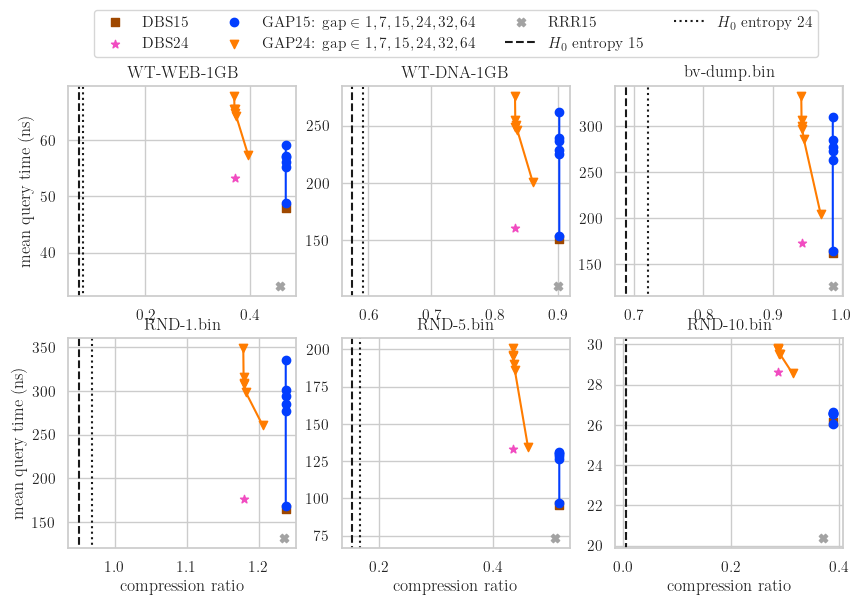

In [268]:
sdf = df[df["machine"] == testset]
plt.figure(figsize=(10, 6))
for i, dat in enumerate(files):
    ddf = sdf[sdf["data_set"] == dat]
    plt.subplot(2, 3, i + 1)
    parts = []
    tdf = ddf[ddf["type"] == "H0GAP15"]
    sdat = sorted([
        (int(g), t, (s + o) / e) 
        for g, t, s, o, e 
        in zip(tdf["gap_size"], tdf["access"], tdf["total_bytes"], tdf["lookup bytes"], tdf["elems"])
    ])
    parts.append((f"GAP15: gap $\\in {{{','.join(str(t[0]) for t in sdat)}}}$", [t[1] for t in sdat], [t[2] for t in sdat], "H0GAP15"))

    tdf = ddf[ddf["type"] == "H0GAP24"]
    sdat = sorted([
        (int(g), t, (s + o) / e) 
        for g, t, s, o, e 
        in zip(tdf["gap_size"], tdf["access"], tdf["total_bytes"], tdf["lookup bytes"], tdf["elems"])
    ])
    parts.append((f"GAP24: gap $\\in {{{','.join(str(t[0]) for t in sdat)}}}$", [t[1] for t in sdat], [t[2] for t in sdat], "H0GAP24"))

    tdf = ddf[ddf["type"].isin(["H0WDBS15", "H0WDBS24"])]
    for a, s, o, e, t, b in zip(tdf["access"], tdf["total_bytes"], tdf["lookup bytes"], tdf["elems"], tdf["type"], tdf["block_size"]):
        parts.append((t[3:], [a],  [(s + o) / e], t))

    tdf = ddf[ddf["type"] == "RRR15"]
    for a, s, o, e, t, b in zip(tdf["access"], tdf["total_bytes"], tdf["lookup bytes"], tdf["elems"], tdf["type"], tdf["block_size"]):
        parts.append((t, [a],  [(s + o) / e], t))

    parts.sort()

    for l, a, s, t in parts:
        plt.scatter(s, a, color=styles[t][0], marker=styles[t][1], label=l)
        if len(a) > 1:
            plt.plot(s, a, color=styles[t][0])
    bot, top = plt.ylim()
    plt.plot([entropy[dat]["15"], entropy[dat]["15"]], [bot/2, top*2], color="k", ls="--", label="$H_0$ entropy 15")
    plt.plot([entropy[dat]["24"], entropy[dat]["24"]], [bot/2, top*2], color="k", ls=":", label="$H_0$ entropy 24")
    plt.ylim((bot, top))
    
    if i == 0 or i == 3:
        plt.ylabel("mean query time (ns)")
    if i >= 3:
        plt.xlabel("compression ratio")
    if i == 1:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=4, fancybox=True)
    plt.title(dat[:-4])
plt.savefig(f"lookup_tables_{testset}.pdf", bbox_inches='tight')
plt.show()


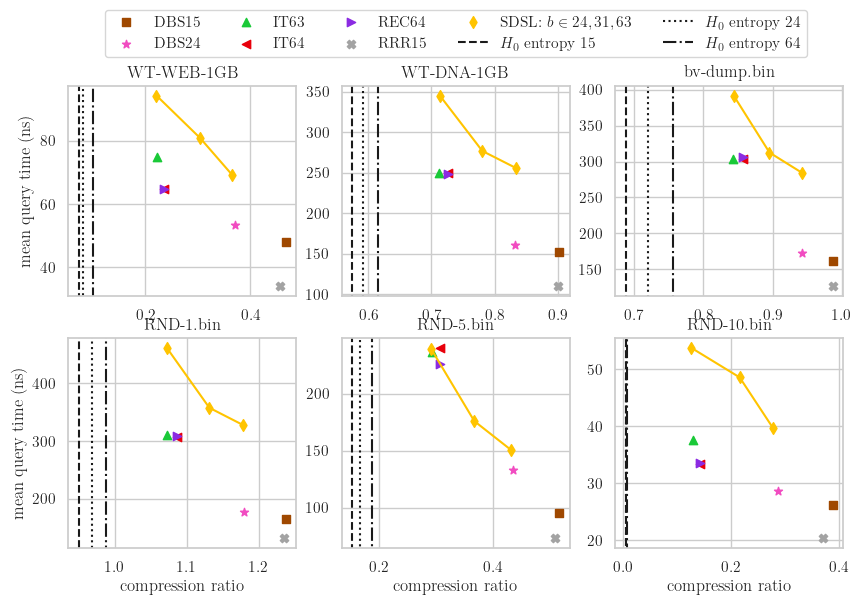

In [269]:
sdf = df[df["machine"] == testset]
sdf = sdf[sdf["block_size"] < 200]
plt.figure(figsize=(10, 6))
for i, dat in enumerate(files):
    plt.subplot(2, 3, i + 1)
    ddf = sdf[sdf["data_set"] == dat]
    pats = []
    tdf = ddf[ddf["type"] == "SDSL"]
    sdat = sorted([
        (b, a, (s + o) / e) 
        for a, s, o, e, b in 
        zip(tdf["access"], tdf["total_bytes"], tdf["lookup bytes"], tdf["elems"], tdf["block_size"])
    ])
    pats.append((
        f"SDSL: $b\\in {','.join(str(t[0]) for t in sdat)}$", 
        [t[1] for t in sdat], 
        [t[2] for t in sdat], 
        "SDSL"
    ))
    tdf = ddf[ddf["type"].isin(['H0I63', 'H0I64', 'H0R64', 'H0WDBS15', 'H0WDBS24', 'RRR15'])]
    tmap = {
        'H0I': 'IT',
        'H0R': 'REC',
        'H0WDBS': 'DBS',
        'RRR': 'RRR'
    }
    for a, s, o, e, t, b in zip(tdf["access"], tdf["total_bytes"], tdf["lookup bytes"], tdf["elems"], tdf["type"], tdf["block_size"]):
        pats.append((f"{tmap[t[:-2]]}{b}", [a], [(s + o) / e], t))

    pats.sort()
    for l, t, s, typ in pats:
        plt.scatter(s, t, color=styles[typ][0], marker=styles[typ][1], label=l)
        if len(t) > 1:
            plt.plot(s, t, color=styles[typ][0])
    bot, top = plt.ylim()
    plt.plot([entropy[dat]["15"], entropy[dat]["15"]], [bot/2, top*2], color="k", ls="--", label="$H_0$ entropy 15")
    plt.plot([entropy[dat]["24"], entropy[dat]["24"]], [bot/2, top*2], color="k", ls=":", label="$H_0$ entropy 24")
    plt.plot([entropy[dat]["64"], entropy[dat]["64"]], [bot/2, top*2], color="k", ls="-.", label="$H_0$ entropy 64")
    plt.ylim((bot, top))
    if i == 0 or i == 3:
        plt.ylabel("mean query time (ns)")
    if i >= 3:
        plt.xlabel("compression ratio")
    if i == 1:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=5, fancybox=True)
    plt.title(dat[:-4])
plt.savefig(f"overall_{testset}.pdf", bbox_inches='tight')
plt.show()

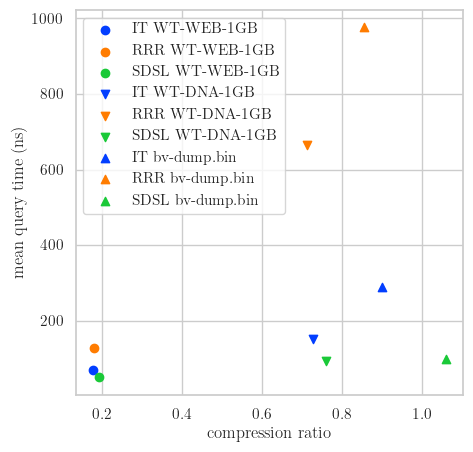

In [270]:
sdf = df[df["machine"] == testset]
sdf = sdf[sdf["type"].str.contains("HYB")]
plt.figure(figsize=(5, 5))
for m, dat in zip("ov^,", files):
    if "RND" in dat:
        continue
    ddf = sdf[sdf["data_set"] == dat]
    dats = []
    for a, s, e, t, b in zip(ddf["access"], ddf["total_bytes"], ddf["elems"], ddf["type"], ddf["block_size"]):
        dats.append((f"{t[:-3] if t.endswith("256") else t}  {b}", [a], [s / e]))
    dats.sort()
    for c, t in zip(sns.color_palette(), dats):
        plt.scatter(t[2], t[1], color=c, marker=m, label=f"{t[0][3:-3]}{dat[:-4]}")
    plt.xlabel("compression ratio")
    plt.ylabel("mean query time (ns)")
    plt.legend()
plt.savefig(f"hybrid_{testset}.pdf", bbox_inches='tight')
plt.show()

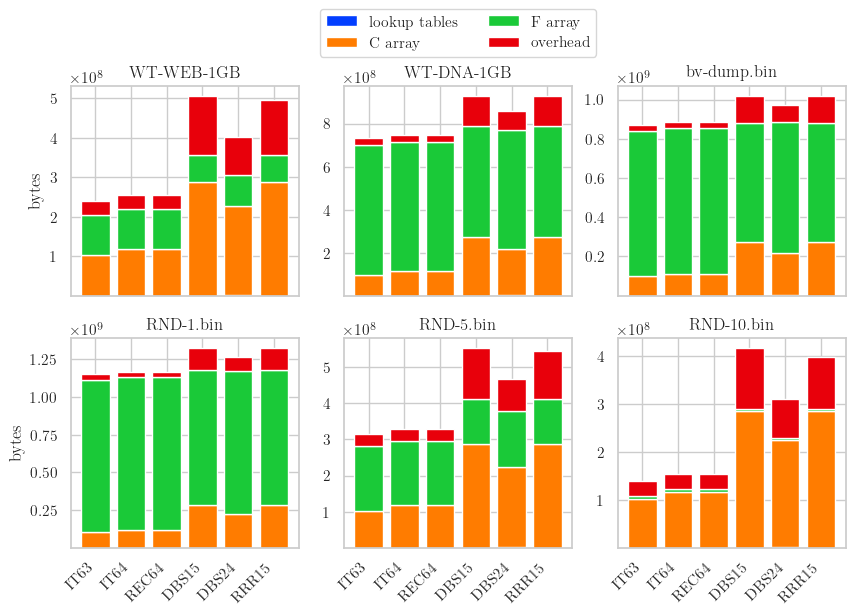

In [271]:
sdf = df[df["machine"] == testset]
sdf = sdf[sdf["block_size"] < 200]
sdf = sdf[sdf["type"].isin(['H0I63', 'H0I64', 'H0R64', 'H0WDBS15', 'H0WDBS24', 'RRR15'])]
tmap = {
    'H0I': 'IT',
    'H0R': 'REC',
    'H0WDBS': 'DBS',
    'RRR': 'RRR'
}
plt.figure(figsize=(10, 6))
for i, dat in enumerate(files):
    tdf = sdf[sdf["data_set"] == dat].sort_values("type")
    plt.subplot(2, 3, i + 1)

    locs = [    
        f"{tmap[t[:-2]]}{b}" 
        for t, b in zip(tdf["type"], tdf["block_size"])
    ]
    lab = locs if i >= 3 else ["" for v in locs]
    bottom = np.zeros(len(locs))
    plt.bar(locs, tdf["lookup bytes"], bottom=bottom, label="lookup tables", tick_label=lab)
    bottom += tdf["lookup bytes"]
    plt.bar(locs, tdf["C bytes"], bottom=bottom, label="C array")
    bottom += tdf["C bytes"]
    plt.bar(locs, tdf["F bytes"], bottom=bottom, label="F array")
    bottom += tdf["F bytes"]
    plt.bar(locs, tdf["overhead bytes"], bottom=bottom, label="overhead")
    plt.xticks(rotation=45, ha='right')
    plt.title(dat[:-4])
    if i == 0 or i == 3:
        plt.ylabel("bytes")
    if i == 1:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, fancybox=True)
plt.savefig(f"space_usage_{testset}.pdf", bbox_inches='tight')
plt.show()

In [240]:
tdf = df[df["data_set"] == "bv-dump.bin.txt"]
tdf = tdf[tdf["type"] == "H0GAP15"]
tdf[tdf["gap_size"] == "1"]

,elems,build time,total_bytes,C bytes,F bytes,overhead bytes,lookup bytes,access,rank,select,data_set,block_size,CR,type,machine,gap_size
76,1.032709e+09,6143,1.019378e+09,275389081.0,606294408.0,137694562.0,42992.0,219.14,258.762,1241.22,bv-dump.bin.txt,15,0.987133,H0GAP15,laptop,1


In [238]:
{(v, type(v)) for v in set(df["gap_size"])}

{('1', str),
 ('15', str),
 ('24', str),
 ('32', str),
 ('64', str),
 ('7', str),
 (nan, float)}

In [224]:
def first(iterable, default = None):
  iterator = iter(iterable)
  return next(iterator, default)

In [272]:
r_types = [
    'H0GAP15',
    'H0GAP24',
    'H0I63',
    'H0I64',
    'H0R64',
    'H0WDBS15',
    'H0WDBS24',
    'RRR15',
    'SDSL',
    'HYBIT256',
    'HYBRRR256',
    'HYBSDSL'
]

rt_map = {
    'H0GAP15': "GAP",
    'H0GAP24': "GAP",
    'H0I63': "IT",
    'H0I64': "IT",
    'H0R64': "REC",
    'H0WDBS15': "DBS",
    'H0WDBS24': "DBS",
    'HYBIT256': "HYB-IT",
    'HYBRRR256': "HYB-RRR",
    'HYBSDSL': "HYB",
    'RRR15': "RRR",
    'SDSL': "SDSL"
}

bs_map = {
    'H0GAP15': [15],
    'H0GAP24': [24],
    'H0I63': [63],
    'H0I64': [64],
    'H0R64': [64],
    'H0WDBS15': [15],
    'H0WDBS24': [24],
    'HYBIT256': [256],
    'HYBRRR256': [256],
    'HYBSDSL': [256],
    'RRR15': [15],
    'SDSL': [24, 31, 63] 
}

gaps = [str(v) for v in [
    1, 7, 15, 24, 32, 64
]]

lins = [
    ("build time", "build time (s)"),
    ("CR", "bits/bit"),
    ("access", "access (ns)"),
    ("rank", "rank (ns)"),
    ("select", "select (ns)")
]

res_table = """\\begin{tabular}{ l |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] }
\\hline
"""
res_table += f" & {' & '.join(f'{{{fn[:-4]}}}' for fn in files)} \\\\\n"
res_table += "\\hline\n"
for t in r_types:
    tdf = df[df["type"] == t]
    for bs in bs_map[t]:
        bdf = tdf[tdf["block_size"] == bs]
        if "GAP" in t:
            for g in gaps:
                gdf = bdf[bdf["gap_size"] == g]
                res_table += f"{{\\bf {rt_map[t]}}} & \\multicolumn{{6}}{{l}}{{block size: {bs}, gap: {g}}} \\\\\n"
                for cn, lab in lins:
                    res_table += f"{lab} & {' & '.join(str(first(gdf[gdf["data_set"] == fn][cn])) for fn in files)} \\\\\n"
                res_table += "\\hline\n"
        else:
            res_table += f"{{\\bf {rt_map[t]}}} & \\multicolumn{{6}}{{l}}{{block size: {bs}}} \\\\\n"
            for cn, lab in lins:
                res_table += f"{lab} & {' & '.join(str(first(bdf[bdf["data_set"] == fn][cn])) for fn in files)} \\\\\n"
            res_table += "\\hline\n"
res_table += "\\end{tabular}"
print(res_table)

\begin{tabular}{ l |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] |
S[table-format=0.1, round-precision = 3, round-mode = figures, scientific-notation = false] }
\hline
 & {WT-WEB-1GB} & {WT-DNA-1GB} & {bv-dump.bin} & {RND-1.bin} & {RND-5.bin} & {RND-10.bin} \\
\hline
{\bf GAP} & \multicolumn{6}{l}{block size: 15, gap: 1} \\
build time (s) & 3.728 & 4.055 & 4.561 & 4.128 & 3.828 & 3.582 \\
bits/bit & 0.46787895101397786 & 0.9027096011991466 & 0.9871330214143029 & 1.2369741062672874 & 0.5161985520929206 & 0.38935580093893557 \\
access (ns) & 48.8088 & 153.222 & 164.145 & 